# Notes

 * 2.2 pixel thing is the nyquist shannon theorem of resolution with some buffer space, exactly how that was decided is unknown to me but that is what it is.

In [1]:
!git config --global user.name "LanceM28" 
!git config --global git config --global user.email "lmoreau@terpmail.umd.edu"

usage: git config [<options>]

Config file location
    --global              use global config file
    --system              use system config file
    --local               use repository config file
    --worktree            use per-worktree config file
    -f, --file <file>     use given config file
    --blob <blob-id>      read config from given blob object

Action
    --get                 get value: name [value-pattern]
    --get-all             get all values: key [value-pattern]
    --get-regexp          get values for regexp: name-regex [value-pattern]
    --get-urlmatch        get value specific for the URL: section[.var] URL
    --replace-all         replace all matching variables: name value [value-pattern]
    --add                 add a new variable: name value
    --unset               remove a variable: name [value-pattern]
    --unset-all           remove all matches: name [value-pattern]
    --rename-section      rename section: old-name new-name
    --remove-secti

In [2]:
from pathlib import Path
from astropy.table import Table

def searcher(start_path, dirname):
    # Start from a high-level but not-too-huge root directory
    search_root = Path(str(start_path))

    # Recursively look for the directory
    matches = list(search_root.rglob(str(dirname)))

    if matches:
        jwst_dir = matches[0]  # Use the first match (or loop over all if multiple found)
        print(f"Found directory: {jwst_dir}")

        # List all files in its subdirectories
        all_files = [f for f in jwst_dir.glob("**/*") if f.is_file()]
        print(f"Found {len(all_files)} files:")
        disp_files = [str(f) for f in all_files if f.suffix == ".fits"]
        file_dict = {}
        for f in disp_files:
            df = Table.read(f)
            dex = (f.split("/")[-1]).split("_")[2]
            file_dict[dex] = df
        return file_dict
    else:
        print(f"No directory named {dirname} found.")
        


In [3]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

Found directory: /Users/lamoreau/python/Aether_Spectroscopy/JWST_FITS_Calibration/NIRSpecdis
Found 7 files:


Found directory: /Users/lamoreau/python/Aether_Spectroscopy/JWST_FITS_Calibration/NIRSpecfil
Found 7 files:
WAVELENGTH
 MICRONS  
----------
       2.5
    2.5026
    2.5052
    2.5078
    2.5104
     2.513
    2.5156
    2.5182
    2.5208
    2.5234
       ...
    5.9762
    5.9788
    5.9814
     5.984
    5.9866
    5.9892
    5.9918
    5.9944
     5.997
       6.0
Length = 1347 rows


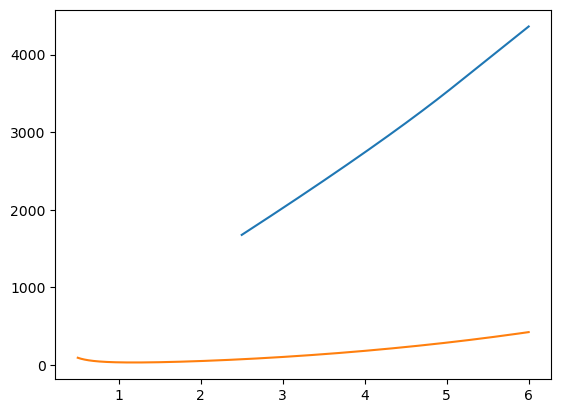

In [4]:
JWST_disp_dict = searcher("/Users/lamoreau/python", "NIRSpecdis")
JWST_fil_dict = searcher("/Users/lamoreau/python", "NIRSpecfil")
print(JWST_disp_dict["g395h"]["WAVELENGTH"])
plt.plot(JWST_disp_dict["g395h"]["WAVELENGTH"], JWST_disp_dict["g395h"]["R"])
plt.plot(JWST_disp_dict["prism"]["WAVELENGTH"], JWST_disp_dict["prism"]["R"])



In [5]:
print(JWST_fil_dict.keys())
print(JWST_disp_dict["g140h"]) #allowed to do this too!


#print(len(JWST_disp_dict["g395m"]["WAVELENGTH"]))
#print(len(JWST_disp_dict["g235m"]["WAVELENGTH"]))
#print(len(JWST_disp_dict["g140m"]["WAVELENGTH"]))

#print(JWST_fil_dict["f140x"]["THROUGHPUT"])

#print(min(JWST_fil_dict["f140x"]["WAVELENGTH"]), max(JWST_fil_dict["f140x"]["WAVELENGTH"]))
#print(min(JWST_fil_dict["clear"]["WAVELENGTH"]), max(JWST_fil_dict["clear"]["WAVELENGTH"]))

#TODO

#need to add functionality to combind filter and disperser settings
#interpolation or binning (try and numbnut!)

dict_keys(['f140x', 'clear', 'f110w', 'f070lp', 'f100lp', 'f290lp', 'f170lp'])
WAVELENGTH      DLDS         R     
 MICRONS   MICRONS/PIXEL RESOLUTION
---------- ------------- ----------
       0.5 0.00024101489   942.9821
    0.5014 0.00024102148   945.5966
    0.5028 0.00024102798  948.21124
    0.5042 0.00024103442   950.8261
    0.5056 0.00024104076  953.44116
     0.507 0.00024104702   956.0564
    0.5084 0.00024105319   958.6719
    0.5098 0.00024105929   961.2875
    0.5112 0.00024106528   963.9033
    0.5126 0.00024107122   966.5194
       ...           ...        ...
    1.8874 0.00022601656  3795.7795
    1.8888 0.00022597554   3799.285
    1.8902 0.00022593439  3802.7935
    1.8916 0.00022589312  3806.3054
     1.893 0.00022585173  3809.8203
    1.8944 0.00022581023  3813.3386
    1.8958 0.00022576861  3816.8604
    1.8972 0.00022572688  3820.3853
    1.8986 0.00022568501  3823.9136
       1.9 0.00022564305   3827.445
Length = 1001 rows


In [6]:
###TODO: Add the corresponding data format for the data files so that we can instantiate the disperser class once for each disperser, then call the binner function for multiple spectra.

class JWST_disperser:
    def __init__(self, disperser_dict): 
        self.respow = np.array(disperser_dict["R"])
        self.dlds = np.array(disperser_dict["DLDS"])
        self.wavelength = np.array(disperser_dict["WAVELENGTH"])
        self.minwave = min(self.wavelength)
        self.maxwave = max(self.wavelength)
    
    def edge_finder(self, wavelengths = None, bin_widths = None, start = None, end = None):
        # Default to instance values if no arguments provided
        if wavelengths is None:
            wavelengths = self.wavelength
        if bin_widths is None:
            bin_widths = self.dlds
        if start is None:
            start = self.minwave
        if end is None:
            end = self.maxwave
        
        # Interpolate bin width as a function of wavelength
        interp_bin_width = interp1d(wavelengths, bin_widths, kind='cubic', fill_value="extrapolate")

        # Create adaptive bins
        bin_edges = [start]
        current = start

        while current < end:
            width = interp_bin_width(current)
            next_edge = current + width
            if next_edge > end:
                break
            bin_edges.append(next_edge)
            current = next_edge

        # Ensure last bin edge reaches the end
        if bin_edges[-1] < end:
            bin_edges.append(end)

        # Convert bin edges to numpy array
        bin_edges = np.array(bin_edges)

        self.bin_edges = bin_edges
        self.interp_bin_width = interp_bin_width
        return bin_edges,start,end, interp_bin_width
    
    def binner(self, lcents, sigmas, lams, fluxes, bin_edges = None): #TODO
        if bin_edges is None:
            bin_edges = self.bin_edges
        ### The below will need to be appended to get arrays of these values for each individual spectrum
        #self.lcents = lcents
        #self.sigmas = sigmas
        #self.lams = lams #the wavelength array (x values)
        #self.fluxes = fluxes #y-values
        #TODO: Breakdown
        if len(sigmas) == 1:
            sigmas = np.ones(len(lcents)) * sigmas
        elif len(sigmas) == len(lcents):
            return
        else:
            print(f"!!!Length mismatch!!! \nLine centers length: {len(lcents)} \nSigmas length: {len((sigmas))} ")
        #set limits for valid bin ranges
        lolims = lcents - 3 * sigmas
        uplims = lcents + 3 * sigmas
        for i in range(lcents):
            #is bin edge within +- 3 sigma of lcent
            boolmsk = lolims[i] <= bin_edges <= uplims[i]
            

            print("not done")
            #loop over lcents (lcents and sigmas should be same dimensional array, len(sigmas) = 1 or len(lcents))
        
        #integrate overfluxes in each bin(how to do coherently without getting binning artifacts for small bins?)
        #make flux plot (histogram?, scatter? line? je ne sais quoi!)
        return 

#TODO: Incorporate dsiperser output into filter to obtain actual filtered spectrum.
class JWST_filter:
    def __init__(self, filter_dict):
        self.throughput = np.array(filter_dict["THROUGHPUT"])
        self.wavelength = np.array(filter_dict["WAVELENGTH"])
        self.minwave = min(self.wavelength)
        self.maxwave = max(self.wavelength)
        
    
    def inter(self):
        import scipy.interpolate as inter
        smth_thr = inter.interp1d(self.wavelength, self.throughput, kind = 'cubic')
        return smth_thr
    
import matplotlib.pyplot as plt
f110w = JWST_filter(JWST_fil_dict["f110w"])
interpolated_test = JWST_filter.inter(f110w)
x = np.linspace(f110w.minwave,f110w.maxwave,2000)
#plt.plot(x, interpolated_test(x))

g140h = JWST_disperser(JWST_disp_dict["g140h"])
eftst = JWST_disperser.edge_finder(g140h)




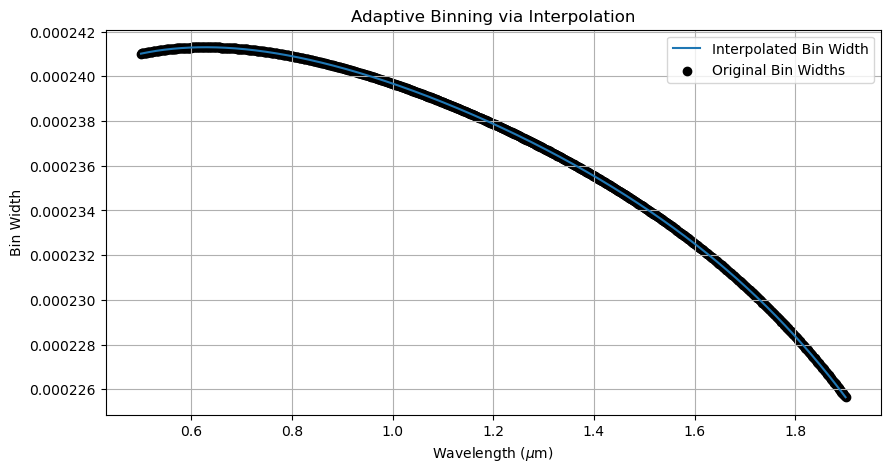

In [7]:
# Example wavelength range and corresponding bin widths
wavelengths = np.array(JWST_disp_dict["g140h"]["WAVELENGTH"])  # e.g., in _m
bin_widths = np.array(JWST_disp_dict["g140h"]["DLDS"])       # bin width at each wavelength



bin_edges, start, end, interp_bin_width = JWST_disperser.edge_finder(g140h)



# Plot the interpolated bin width function and the bin edges
x_dense = np.linspace(start, end, 1000)
y_interp = interp_bin_width(x_dense)

plt.figure(figsize=(10,5))
plt.plot(x_dense, y_interp, label='Interpolated Bin Width')
#plt.vlines(bin_edges, ymin=0, ymax=max(bin_widths), color='red', linestyles='dashed', label='Bin Edges')
plt.scatter(wavelengths, bin_widths, color='black', label='Original Bin Widths')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Bin Width')
#plt.xlim(1.89,1.9)
plt.title('Adaptive Binning via Interpolation')
plt.legend()
plt.grid(True)
plt.show()


# Relics

In [8]:
import numpy as np

import matplotlib.pyplot as plt



"""print(df.columns)
binmrk = np.array(df["DLDS"])
binsz = -np.diff(binmrk)
#print(binsz) #this should return the bin size of my 

print(df)

waves = np.array(df["WAVELENGTH"])
binwave = np.zeros(len(waves)-1)
for i in range(len(waves)-1):
    binwave[i] = (waves[i] + waves[i+1])/2

print(binwave)
plt.figure()
plt.plot(binwave, binsz)
plt.ylabel("Bin Size (DLDS)")
plt.xlabel("Wavelength ((mu)m)")
plt.show()"""


'print(df.columns)\nbinmrk = np.array(df["DLDS"])\nbinsz = -np.diff(binmrk)\n#print(binsz) #this should return the bin size of my \n\nprint(df)\n\nwaves = np.array(df["WAVELENGTH"])\nbinwave = np.zeros(len(waves)-1)\nfor i in range(len(waves)-1):\n    binwave[i] = (waves[i] + waves[i+1])/2\n\nprint(binwave)\nplt.figure()\nplt.plot(binwave, binsz)\nplt.ylabel("Bin Size (DLDS)")\nplt.xlabel("Wavelength ((mu)m)")\nplt.show()'

In [9]:
from pathlib import Path

file_name = "hydro_file_descriptor.txt"
absolute_path_pathlib = Path(file_name).resolve()
print(f"Absolute path using pathlib: {str(absolute_path_pathlib)}")

Absolute path using pathlib: /Users/lamoreau/python/Aether Spectroscopy/BradenNebularLines/hydro_file_descriptor.txt


# Fits opener

Takes fits files and opens them, need to add functionality to allow for wavelength extraction

In [10]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

df = Table.read('file_name')

print(df.columns)
binmrk = np.array(df["DLDS"])
binsz = -np.diff(binmrk)
#print(binsz) #this should return the bin size of my 

print(df)

"""waves = np.array(df["WAVELENGTH"])
binwave = np.zeros(len(waves)-1)
for i in range(len(waves)-1):
    binwave[i] = (waves[i] + waves[i+1])/2

print(binwave)
plt.figure()
plt.plot(binwave, binsz)
plt.ylabel("Bin Size (DLDS)")
plt.xlabel("Wavelength ((mu)m)")
plt.show()"""


FileNotFoundError: [Errno 2] No such file or directory: 'file_name'